In [1]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import keras

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Transformers version:", transformers.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


d:\Project_NEW\Grader\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NumPy version: 1.26.4
Pandas version: 2.2.2
Transformers version: 4.44.2
TensorFlow version: 2.17.0
Keras version: 3.5.0


In [2]:
# Configuration
max_length = 128
batch_size = 32
epochs = 2
labels = ["contradiction", "entailment", "neutral"]

In [3]:

# !curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
# !tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 11.1M    0 36544    0     0  47673      0  0:04:06 --:--:--  0:04:06 47958
 12 11.1M   12 1470k    0     0   600k      0  0:00:19  0:00:02  0:00:17  601k
 15 11.1M   15 1726k    0     0   622k      0  0:00:18  0:00:02  0:00:16  623k
 26 11.1M   26 3006k    0     0   798k      0  0:00:14  0:00:03  0:00:11  799k
 37 11.1M   37 4334k    0     0   909k      0  0:00:12  0:00:04  0:00:08  910k
 45 11.1M   45 5246k    0     0   909k      0  0:00:12  0:00:05  0:00:07 1041k
 55 11.1M   55 6334k    0     0   935k      0  0:00:12  0:00:06  0:00:06 1125k
 70 11.1M   70 8062k    0     0  1037k      0  0:00:11  0:00:07  0:00:04 1267k
 86 11.1M   86 9854k    0     0  1122k      0  0:00:10  0:00:08  0:00:02 1367k
 99 11.1M   99 11.1M    0     0  1169k      0  0:00

In [4]:
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

In [8]:
train_df.dropna(axis=0, inplace=True)

In [12]:
valid_df.similarity.value_counts()

similarity
entailment       3329
contradiction    3278
neutral          3235
Name: count, dtype: int64

In [15]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [16]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [52]:
import tensorflow as tf
import numpy as np
from transformers import BertTokenizer
#generate batches of sentence pairs and their corresponding labels for a BERT model
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, sentence_pairs, labels, batch_size=32, shuffle=True, include_targets=True):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        #loads the pretrained BERT tokenizer (bert-base-uncased version)
        #transform raw text into a format that BERT can process
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
        
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()
# number of batches per epoch
    def __len__(self):
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=128,
            return_attention_mask=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_tensors="tf",
        )

        input_ids = encoded["input_ids"]
        attention_mask = encoded["attention_mask"]
        token_type_ids = encoded["token_type_ids"]

        if self.include_targets:
            labels = tf.convert_to_tensor(self.labels[indexes], dtype=tf.float32)
            return {"input_ids": input_ids, "attention_mask": attention_mask, "token_type_ids": token_type_ids}, labels
        else:
            return {"input_ids": input_ids, "attention_mask": attention_mask, "token_type_ids": token_type_ids}

# shuffle the data if shuffling is enabled
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [53]:
import tensorflow as tf
from tensorflow import keras
from transformers import TFBertModel, BertTokenizer

# Define input shapes
max_length = 128  # Adjust this based on your tokenizer's max_length

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

class CustomBertModel(tf.keras.Model):
    def __init__(self, bert_model, max_length, num_classes):
        super().__init__()
        self.bert = bert_model
        self.bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.max_pool = tf.keras.layers.GlobalMaxPooling1D()
        self.concat = tf.keras.layers.Concatenate()
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = bert_output.last_hidden_state

        bi_lstm_output = self.bi_lstm(sequence_output)
        avg_pool_output = self.avg_pool(bi_lstm_output)
        max_pool_output = self.max_pool(bi_lstm_output)
        concat_output = self.concat([avg_pool_output, max_pool_output])
        dropout_output = self.dropout(concat_output)
        final_output = self.dense(dropout_output)

        return final_output

# Create the model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
model = CustomBertModel(bert_model, max_length=128, num_classes=3)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
# Create train and validation data generators
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
)


d:\Project_NEW\Grader\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/2


d:\Project_NEW\Grader\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
d:\Project_NEW\Grader\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  21/3121 ━━━━━━━━━━━━━━━━━━━━ 2:13:29 3s/step - accuracy: 0.3363 - loss: 1.1698

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  23/3121 ━━━━━━━━━━━━━━━━━━━━ 2:13:58 3s/step - accuracy: 0.3405 - loss: 1.1647

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  43/3121 ━━━━━━━━━━━━━━━━━━━━ 2:09:51 3s/step - accuracy: 0.3717 - loss: 1.1305

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  74/3121 ━━━━━━━━━━━━━━━━━━━━ 2:06:17 2s/step - accuracy: 0.4011 - loss: 1.1017

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 100/3121 ━━━━━━━━━━━━━━━━━━━━ 2:04:35 2s/step - accuracy: 0.4171 - loss: 1.0849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 199/3121 ━━━━━━━━━━━━━━━━━━━━ 1:59:34 2s/step - accuracy: 0.4632 - loss: 1.0340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 202/3121 ━━━━━━━━━━━━━━━━━━━━ 1:59:32 2s/step - accuracy: 0.4643 - loss: 1.0327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 212/3121 ━━━━━━━━━━━━━━━━━━━━ 1:59:59 2s/step - accuracy: 0.4678 - loss: 1.0286

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 234/3121 ━━━━━━━━━━━━━━━━━━━━ 1:59:19 2s/step - accuracy: 0.4751 - loss: 1.0198

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 261/3121 ━━━━━━━━━━━━━━━━━━━━ 1:58:01 2s/step - accuracy: 0.4837 - loss: 1.0094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 271/3121 ━━━━━━━━━━━━━━━━━━━━ 1:57:34 2s/step - accuracy: 0.4867 - loss: 1.0057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 340/3121 ━━━━━━━━━━━━━━━━━━━━ 1:54:18 2s/step - accuracy: 0.5047 - loss: 0.9833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 426/3121 ━━━━━━━━━━━━━━━━━━━━ 1:50:11 2s/step - accuracy: 0.5235 - loss: 0.9590

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 479/3121 ━━━━━━━━━━━━━━━━━━━━ 1:47:50 2s/step - accuracy: 0.5337 - loss: 0.9455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 524/3121 ━━━━━━━━━━━━━━━━━━━━ 1:45:54 2s/step - accuracy: 0.5415 - loss: 0.9348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 578/3121 ━━━━━━━━━━━━━━━━━━━━ 1:43:47 2s/step - accuracy: 0.5502 - loss: 0.9228

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 591/3121 ━━━━━━━━━━━━━━━━━━━━ 1:43:16 2s/step - accuracy: 0.5522 - loss: 0.9200

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 634/3121 ━━━━━━━━━━━━━━━━━━━━ 1:41:40 2s/step - accuracy: 0.5586 - loss: 0.9109

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 705/3121 ━━━━━━━━━━━━━━━━━━━━ 1:38:36 2s/step - accuracy: 0.5682 - loss: 0.8971

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 706/3121 ━━━━━━━━━━━━━━━━━━━━ 1:38:34 2s/step - accuracy: 0.5683 - loss: 0.8969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 710/3121 ━━━━━━━━━━━━━━━━━━━━ 1:38:26 2s/step - accuracy: 0.5688 - loss: 0.8962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 746/3121 ━━━━━━━━━━━━━━━━━━━━ 1:36:55 2s/step - accuracy: 0.5733 - loss: 0.8897

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 748/3121 ━━━━━━━━━━━━━━━━━━━━ 1:36:51 2s/step - accuracy: 0.5735 - loss: 0.8893

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 791/3121 ━━━━━━━━━━━━━━━━━━━━ 1:35:01 2s/step - accuracy: 0.5786 - loss: 0.8820

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 955/3121 ━━━━━━━━━━━━━━━━━━━━ 1:28:24 2s/step - accuracy: 0.5954 - loss: 0.8570

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 968/3121 ━━━━━━━━━━━━━━━━━━━━ 1:27:52 2s/step - accuracy: 0.5966 - loss: 0.8552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 988/3121 ━━━━━━━━━━━━━━━━━━━━ 1:27:02 2s/step - accuracy: 0.5984 - loss: 0.8526

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1011/3121 ━━━━━━━━━━━━━━━━━━━━ 1:26:05 2s/step - accuracy: 0.6003 - loss: 0.8495

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1031/3121 ━━━━━━━━━━━━━━━━━━━━ 1:25:16 2s/step - accuracy: 0.6020 - loss: 0.8470

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1058/3121 ━━━━━━━━━━━━━━━━━━━━ 1:24:10 2s/step - accuracy: 0.6042 - loss: 0.8436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1105/3121 ━━━━━━━━━━━━━━━━━━━━ 1:22:15 2s/step - accuracy: 0.6079 - loss: 0.8380

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1162/3121 ━━━━━━━━━━━━━━━━━━━━ 1:20:00 2s/step - accuracy: 0.6121 - loss: 0.8316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1176/3121 ━━━━━━━━━━━━━━━━━━━━ 1:19:26 2s/step - accuracy: 0.6131 - loss: 0.8300

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1197/3121 ━━━━━━━━━━━━━━━━━━━━ 1:18:34 2s/step - accuracy: 0.6146 - loss: 0.8278

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1258/3121 ━━━━━━━━━━━━━━━━━━━━ 1:16:04 2s/step - accuracy: 0.6186 - loss: 0.8216

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1283/3121 ━━━━━━━━━━━━━━━━━━━━ 1:15:03 2s/step - accuracy: 0.6202 - loss: 0.8191

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1287/3121 ━━━━━━━━━━━━━━━━━━━━ 1:14:53 2s/step - accuracy: 0.6205 - loss: 0.8187

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1301/3121 ━━━━━━━━━━━━━━━━━━━━ 1:14:19 2s/step - accuracy: 0.6213 - loss: 0.8174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1313/3121 ━━━━━━━━━━━━━━━━━━━━ 1:13:50 2s/step - accuracy: 0.6221 - loss: 0.8162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1376/3121 ━━━━━━━━━━━━━━━━━━━━ 1:11:15 2s/step - accuracy: 0.6258 - loss: 0.8104

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1401/3121 ━━━━━━━━━━━━━━━━━━━━ 1:10:14 2s/step - accuracy: 0.6272 - loss: 0.8082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1581/3121 ━━━━━━━━━━━━━━━━━━━━ 1:02:50 2s/step - accuracy: 0.6365 - loss: 0.7935

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1594/3121 ━━━━━━━━━━━━━━━━━━━━ 1:02:18 2s/step - accuracy: 0.6371 - loss: 0.7925

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1624/3121 ━━━━━━━━━━━━━━━━━━━━ 1:01:05 2s/step - accuracy: 0.6385 - loss: 0.7903

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1641/3121 ━━━━━━━━━━━━━━━━━━━━ 1:00:24 2s/step - accuracy: 0.6393 - loss: 0.7891

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1650/3121 ━━━━━━━━━━━━━━━━━━━━ 1:00:02 2s/step - accuracy: 0.6397 - loss: 0.7884

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1671/3121 ━━━━━━━━━━━━━━━━━━━━ 59:11 2s/step - accuracy: 0.6406 - loss: 0.7869

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1728/3121 ━━━━━━━━━━━━━━━━━━━━ 56:51 2s/step - accuracy: 0.6431 - loss: 0.7830

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1806/3121 ━━━━━━━━━━━━━━━━━━━━ 53:40 2s/step - accuracy: 0.6463 - loss: 0.7778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1846/3121 ━━━━━━━━━━━━━━━━━━━━ 52:03 2s/step - accuracy: 0.6479 - loss: 0.7753

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1897/3121 ━━━━━━━━━━━━━━━━━━━━ 49:58 2s/step - accuracy: 0.6498 - loss: 0.7722

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1898/3121 ━━━━━━━━━━━━━━━━━━━━ 49:56 2s/step - accuracy: 0.6498 - loss: 0.7721

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1937/3121 ━━━━━━━━━━━━━━━━━━━━ 48:21 2s/step - accuracy: 0.6513 - loss: 0.7698

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1939/3121 ━━━━━━━━━━━━━━━━━━━━ 48:16 2s/step - accuracy: 0.6513 - loss: 0.7696

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2004/3121 ━━━━━━━━━━━━━━━━━━━━ 45:37 2s/step - accuracy: 0.6537 - loss: 0.7659

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2047/3121 ━━━━━━━━━━━━━━━━━━━━ 43:52 2s/step - accuracy: 0.6551 - loss: 0.7635

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2064/3121 ━━━━━━━━━━━━━━━━━━━━ 43:10 2s/step - accuracy: 0.6557 - loss: 0.7625

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2184/3121 ━━━━━━━━━━━━━━━━━━━━ 38:16 2s/step - accuracy: 0.6596 - loss: 0.7562

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2226/3121 ━━━━━━━━━━━━━━━━━━━━ 36:34 2s/step - accuracy: 0.6609 - loss: 0.7541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2282/3121 ━━━━━━━━━━━━━━━━━━━━ 34:16 2s/step - accuracy: 0.6625 - loss: 0.7514

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2283/3121 ━━━━━━━━━━━━━━━━━━━━ 34:14 2s/step - accuracy: 0.6626 - loss: 0.7513

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2331/3121 ━━━━━━━━━━━━━━━━━━━━ 32:16 2s/step - accuracy: 0.6640 - loss: 0.7490

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2347/3121 ━━━━━━━━━━━━━━━━━━━━ 31:37 2s/step - accuracy: 0.6644 - loss: 0.7483

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2471/3121 ━━━━━━━━━━━━━━━━━━━━ 26:33 2s/step - accuracy: 0.6678 - loss: 0.7427

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2503/3121 ━━━━━━━━━━━━━━━━━━━━ 25:15 2s/step - accuracy: 0.6687 - loss: 0.7413

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2511/3121 ━━━━━━━━━━━━━━━━━━━━ 24:56 2s/step - accuracy: 0.6689 - loss: 0.7410

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2532/3121 ━━━━━━━━━━━━━━━━━━━━ 24:04 2s/step - accuracy: 0.6694 - loss: 0.7401

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2545/3121 ━━━━━━━━━━━━━━━━━━━━ 23:32 2s/step - accuracy: 0.6697 - loss: 0.7395

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2584/3121 ━━━━━━━━━━━━━━━━━━━━ 21:57 2s/step - accuracy: 0.6707 - loss: 0.7379

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2613/3121 ━━━━━━━━━━━━━━━━━━━━ 20:45 2s/step - accuracy: 0.6715 - loss: 0.7367

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2688/3121 ━━━━━━━━━━━━━━━━━━━━ 17:41 2s/step - accuracy: 0.6733 - loss: 0.7337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2726/3121 ━━━━━━━━━━━━━━━━━━━━ 16:08 2s/step - accuracy: 0.6742 - loss: 0.7322

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2732/3121 ━━━━━━━━━━━━━━━━━━━━ 15:53 2s/step - accuracy: 0.6743 - loss: 0.7320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2814/3121 ━━━━━━━━━━━━━━━━━━━━ 12:32 2s/step - accuracy: 0.6762 - loss: 0.7289

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2824/3121 ━━━━━━━━━━━━━━━━━━━━ 12:08 2s/step - accuracy: 0.6764 - loss: 0.7285

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2842/3121 ━━━━━━━━━━━━━━━━━━━━ 11:23 2s/step - accuracy: 0.6768 - loss: 0.7279

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2984/3121 ━━━━━━━━━━━━━━━━━━━━ 5:35 2s/step - accuracy: 0.6798 - loss: 0.7229

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2986/3121 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.6798 - loss: 0.7228

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2994/3121 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.6800 - loss: 0.7225

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3027/3121 ━━━━━━━━━━━━━━━━━━━━ 3:50 2s/step - accuracy: 0.6806 - loss: 0.7214

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6825 - loss: 0.7183

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 ━━━━━━━━━━━━━━━━━━━━ 8436s 3s/step - accuracy: 0.6825 - loss: 0.7183 - val_accuracy: 0.7961 - val_loss: 0.5156
Epoch 2/2
  24/3121 ━━━━━━━━━━━━━━━━━━━━ 2:10:46 3s/step - accuracy: 0.8013 - loss: 0.4919

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  47/3121 ━━━━━━━━━━━━━━━━━━━━ 2:09:49 3s/step - accuracy: 0.8013 - loss: 0.5011

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  73/3121 ━━━━━━━━━━━━━━━━━━━━ 2:11:13 3s/step - accuracy: 0.8015 - loss: 0.5039

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  96/3121 ━━━━━━━━━━━━━━━━━━━━ 2:07:55 3s/step - accuracy: 0.8013 - loss: 0.5063

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 108/3121 ━━━━━━━━━━━━━━━━━━━━ 2:06:28 3s/step - accuracy: 0.8012 - loss: 0.5070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 157/3121 ━━━━━━━━━━━━━━━━━━━━ 2:02:26 2s/step - accuracy: 0.8007 - loss: 0.5077

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 158/3121 ━━━━━━━━━━━━━━━━━━━━ 2:02:22 2s/step - accuracy: 0.8007 - loss: 0.5077

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 179/3121 ━━━━━━━━━━━━━━━━━━━━ 2:00:53 2s/step - accuracy: 0.8001 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 216/3121 ━━━━━━━━━━━━━━━━━━━━ 1:58:41 2s/step - accuracy: 0.7993 - loss: 0.5091

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 247/3121 ━━━━━━━━━━━━━━━━━━━━ 1:56:45 2s/step - accuracy: 0.7993 - loss: 0.5088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 334/3121 ━━━━━━━━━━━━━━━━━━━━ 1:52:03 2s/step - accuracy: 0.7989 - loss: 0.5086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 381/3121 ━━━━━━━━━━━━━━━━━━━━ 1:49:43 2s/step - accuracy: 0.7985 - loss: 0.5089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 395/3121 ━━━━━━━━━━━━━━━━━━━━ 1:49:20 2s/step - accuracy: 0.7984 - loss: 0.5091

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 434/3121 ━━━━━━━━━━━━━━━━━━━━ 1:47:28 2s/step - accuracy: 0.7980 - loss: 0.5095

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 567/3121 ━━━━━━━━━━━━━━━━━━━━ 1:41:14 2s/step - accuracy: 0.7977 - loss: 0.5089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 609/3121 ━━━━━━━━━━━━━━━━━━━━ 1:39:22 2s/step - accuracy: 0.7978 - loss: 0.5085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 652/3121 ━━━━━━━━━━━━━━━━━━━━ 1:37:28 2s/step - accuracy: 0.7978 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 790/3121 ━━━━━━━━━━━━━━━━━━━━ 1:31:36 2s/step - accuracy: 0.7981 - loss: 0.5068

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 814/3121 ━━━━━━━━━━━━━━━━━━━━ 1:30:38 2s/step - accuracy: 0.7982 - loss: 0.5066

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 848/3121 ━━━━━━━━━━━━━━━━━━━━ 1:29:14 2s/step - accuracy: 0.7982 - loss: 0.5064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 941/3121 ━━━━━━━━━━━━━━━━━━━━ 1:25:40 2s/step - accuracy: 0.7982 - loss: 0.5060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 943/3121 ━━━━━━━━━━━━━━━━━━━━ 1:25:36 2s/step - accuracy: 0.7982 - loss: 0.5059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 954/3121 ━━━━━━━━━━━━━━━━━━━━ 1:25:11 2s/step - accuracy: 0.7982 - loss: 0.5059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1004/3121 ━━━━━━━━━━━━━━━━━━━━ 1:23:21 2s/step - accuracy: 0.7982 - loss: 0.5058

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1011/3121 ━━━━━━━━━━━━━━━━━━━━ 1:23:05 2s/step - accuracy: 0.7982 - loss: 0.5058

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1039/3121 ━━━━━━━━━━━━━━━━━━━━ 1:22:02 2s/step - accuracy: 0.7981 - loss: 0.5057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1056/3121 ━━━━━━━━━━━━━━━━━━━━ 1:21:23 2s/step - accuracy: 0.7981 - loss: 0.5057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1066/3121 ━━━━━━━━━━━━━━━━━━━━ 1:21:00 2s/step - accuracy: 0.7981 - loss: 0.5057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1075/3121 ━━━━━━━━━━━━━━━━━━━━ 1:20:39 2s/step - accuracy: 0.7981 - loss: 0.5057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1262/3121 ━━━━━━━━━━━━━━━━━━━━ 1:13:15 2s/step - accuracy: 0.7978 - loss: 0.5059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1304/3121 ━━━━━━━━━━━━━━━━━━━━ 1:11:35 2s/step - accuracy: 0.7977 - loss: 0.5059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1314/3121 ━━━━━━━━━━━━━━━━━━━━ 1:11:12 2s/step - accuracy: 0.7977 - loss: 0.5059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1355/3121 ━━━━━━━━━━━━━━━━━━━━ 1:09:34 2s/step - accuracy: 0.7977 - loss: 0.5060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1357/3121 ━━━━━━━━━━━━━━━━━━━━ 1:09:29 2s/step - accuracy: 0.7977 - loss: 0.5060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1377/3121 ━━━━━━━━━━━━━━━━━━━━ 1:08:41 2s/step - accuracy: 0.7976 - loss: 0.5060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1399/3121 ━━━━━━━━━━━━━━━━━━━━ 1:07:49 2s/step - accuracy: 0.7976 - loss: 0.5060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1437/3121 ━━━━━━━━━━━━━━━━━━━━ 1:06:18 2s/step - accuracy: 0.7975 - loss: 0.5061

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1505/3121 ━━━━━━━━━━━━━━━━━━━━ 1:03:37 2s/step - accuracy: 0.7974 - loss: 0.5063

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1551/3121 ━━━━━━━━━━━━━━━━━━━━ 1:01:47 2s/step - accuracy: 0.7973 - loss: 0.5064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1652/3121 ━━━━━━━━━━━━━━━━━━━━ 57:46 2s/step - accuracy: 0.7971 - loss: 0.5066

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1712/3121 ━━━━━━━━━━━━━━━━━━━━ 55:23 2s/step - accuracy: 0.7970 - loss: 0.5068

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1730/3121 ━━━━━━━━━━━━━━━━━━━━ 54:41 2s/step - accuracy: 0.7970 - loss: 0.5069

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1812/3121 ━━━━━━━━━━━━━━━━━━━━ 51:26 2s/step - accuracy: 0.7968 - loss: 0.5071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1822/3121 ━━━━━━━━━━━━━━━━━━━━ 51:02 2s/step - accuracy: 0.7968 - loss: 0.5071

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1865/3121 ━━━━━━━━━━━━━━━━━━━━ 49:20 2s/step - accuracy: 0.7968 - loss: 0.5073

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1955/3121 ━━━━━━━━━━━━━━━━━━━━ 45:47 2s/step - accuracy: 0.7966 - loss: 0.5075

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2049/3121 ━━━━━━━━━━━━━━━━━━━━ 42:04 2s/step - accuracy: 0.7965 - loss: 0.5077

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2056/3121 ━━━━━━━━━━━━━━━━━━━━ 41:48 2s/step - accuracy: 0.7965 - loss: 0.5077

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2057/3121 ━━━━━━━━━━━━━━━━━━━━ 41:45 2s/step - accuracy: 0.7965 - loss: 0.5077

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2087/3121 ━━━━━━━━━━━━━━━━━━━━ 40:35 2s/step - accuracy: 0.7964 - loss: 0.5078

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2158/3121 ━━━━━━━━━━━━━━━━━━━━ 37:47 2s/step - accuracy: 0.7964 - loss: 0.5079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2161/3121 ━━━━━━━━━━━━━━━━━━━━ 37:40 2s/step - accuracy: 0.7963 - loss: 0.5079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2192/3121 ━━━━━━━━━━━━━━━━━━━━ 36:27 2s/step - accuracy: 0.7963 - loss: 0.5079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2230/3121 ━━━━━━━━━━━━━━━━━━━━ 34:57 2s/step - accuracy: 0.7963 - loss: 0.5079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2235/3121 ━━━━━━━━━━━━━━━━━━━━ 34:45 2s/step - accuracy: 0.7963 - loss: 0.5079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2311/3121 ━━━━━━━━━━━━━━━━━━━━ 31:47 2s/step - accuracy: 0.7963 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2323/3121 ━━━━━━━━━━━━━━━━━━━━ 31:18 2s/step - accuracy: 0.7963 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2353/3121 ━━━━━━━━━━━━━━━━━━━━ 30:08 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2357/3121 ━━━━━━━━━━━━━━━━━━━━ 29:58 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2404/3121 ━━━━━━━━━━━━━━━━━━━━ 28:08 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2409/3121 ━━━━━━━━━━━━━━━━━━━━ 27:56 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2420/3121 ━━━━━━━━━━━━━━━━━━━━ 27:30 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2423/3121 ━━━━━━━━━━━━━━━━━━━━ 27:23 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2445/3121 ━━━━━━━━━━━━━━━━━━━━ 26:31 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2446/3121 ━━━━━━━━━━━━━━━━━━━━ 26:29 2s/step - accuracy: 0.7962 - loss: 0.5080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2471/3121 ━━━━━━━━━━━━━━━━━━━━ 25:30 2s/step - accuracy: 0.7962 - loss: 0.5081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2538/3121 ━━━━━━━━━━━━━━━━━━━━ 22:52 2s/step - accuracy: 0.7962 - loss: 0.5081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2590/3121 ━━━━━━━━━━━━━━━━━━━━ 20:50 2s/step - accuracy: 0.7961 - loss: 0.5081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2610/3121 ━━━━━━━━━━━━━━━━━━━━ 20:03 2s/step - accuracy: 0.7961 - loss: 0.5082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2671/3121 ━━━━━━━━━━━━━━━━━━━━ 17:39 2s/step - accuracy: 0.7961 - loss: 0.5082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2687/3121 ━━━━━━━━━━━━━━━━━━━━ 17:02 2s/step - accuracy: 0.7961 - loss: 0.5082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2777/3121 ━━━━━━━━━━━━━━━━━━━━ 13:30 2s/step - accuracy: 0.7960 - loss: 0.5083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2874/3121 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.7960 - loss: 0.5083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2875/3121 ━━━━━━━━━━━━━━━━━━━━ 9:39 2s/step - accuracy: 0.7960 - loss: 0.5083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2901/3121 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.7960 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2908/3121 ━━━━━━━━━━━━━━━━━━━━ 8:21 2s/step - accuracy: 0.7960 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2951/3121 ━━━━━━━━━━━━━━━━━━━━ 6:40 2s/step - accuracy: 0.7960 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2968/3121 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.7960 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3032/3121 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - accuracy: 0.7960 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7960 - loss: 0.5084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 ━━━━━━━━━━━━━━━━━━━━ 8061s 3s/step - accuracy: 0.7960 - loss: 0.5084 - val_accuracy: 0.8092 - val_loss: 0.4778


In [55]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


d:\Project_NEW\Grader\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
d:\Project_NEW\Grader\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 72/312 ━━━━━━━━━━━━━━━━━━━━ 9:37 2s/step - accuracy: 0.7957 - loss: 0.5096

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 85/312 ━━━━━━━━━━━━━━━━━━━━ 9:06 2s/step - accuracy: 0.7957 - loss: 0.5097

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


312/312 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.7991 - loss: 0.5012
Test Loss: 0.4938
Test Accuracy: 0.8013


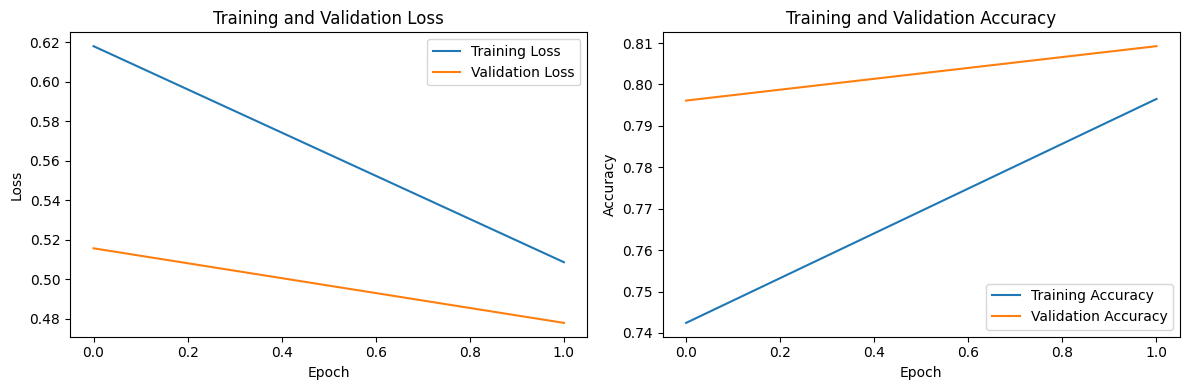

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
def predict_similarity(sentence1, sentence2):
    sentence_pair = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pair, labels=None, batch_size=1, shuffle=False, include_targets=False
    )
    prediction = model.predict(test_data)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    
    labels = ["contradiction", "entailment", "neutral"]
    return labels[predicted_class], confidence

# Example usage


sentence1 = "An operating system (OS) is system software that manages hardware and software resources, provides services to computer programs, and enables user interaction with the device."
sentence2 = "An operating system (OS) is software that controls the computer’s hardware and software. It manages resources like memory and processors, runs applications, and allows users to interact with the computer."
result, confidence = predict_similarity(sentence1, sentence2)
print(f"Predicted relationship: {result}")
print(f"Confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted relationship: entailment
Confidence: 0.8284


## Save entire model

In [62]:
model.save('bert_semantic_similarity_model.h5')


In [65]:
# Save only the weights
model.save_weights('bert_text_classifier.weights.h5')

In [68]:
# Save the model using the TensorFlow `SavedModel` format
model.save('bert_semantic_similarity_model.keras')

In [69]:
with keras.utils.custom_object_scope({'CustomBertModel': CustomBertModel}):
    model.save('bert_semantic_similarity_model.keras')


In [70]:
sentence1 = "Force is a pull or push that change or tends to change the position of a body."
sentence2 = "Force is strength or energy as an attribute of physical action or movement."
result, confidence = predict_similarity(sentence1, sentence2)
print(f"Predicted relationship: {result}")
print(f"Confidence: {confidence:.4f}")

d:\Project_NEW\Grader\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
d:\Project_NEW\Grader\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted relationship: entailment
Confidence: 0.8895
